# QVM Engine v3f - Top 200 Universe Implementation

**Objective:** Complete implementation of QVM Engine v3f with top 200 stocks by ADTV
and comprehensive performance analysis including equity curve generation.

**File:** 06_qvm_engine_v3f.py

---

In [43]:
# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from pathlib import Path
import sys
import yaml

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore')
# Removed global pandas display format to avoid interference with percentage displays

In [44]:
# --- Add Project Root to Python Path ---
try:
    current_path = Path.cwd()
    while not (current_path / 'production').is_dir():
        if current_path.parent == current_path:
            raise FileNotFoundError("Could not find the 'production' directory.")
        current_path = current_path.parent
    
    project_root = current_path
    
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    
    from production.database.connection import get_database_manager
    from production.database.mappings.financial_mapping_manager import FinancialMappingManager
    print(f"✅ Successfully imported production modules.")
    print(f"   - Project Root set to: {project_root}")

except (ImportError, FileNotFoundError) as e:
    print(f"❌ ERROR: Could not import production modules. Please check your directory structure.")
    print(f"   - Final Path Searched: {project_root}")
    print(f"   - Error: {e}")
    raise

✅ Successfully imported production modules.
   - Project Root set to: /Users/raymond/Documents/Projects/factor-investing-public


In [45]:
# --- QVM Engine v3f Top 200 Universe Configuration ---
QVM_CONFIG = {
    # --- Backtest Parameters ---
    "strategy_name": "QVM_Engine_v3h_Fixed_Regime",
    "backtest_start_date": "2016-01-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "M", # Monthly
    "transaction_cost_bps": 30, # Flat 30bps

    # --- Universe Construction ---
    "universe": {
        "lookback_days": 63,
        "top_n_stocks": 200,  # Top 200 stocks by ADTV
        "max_position_size": 0.05,
        "max_sector_exposure": 0.30,
        "target_portfolio_size": 20,
    },

    # --- Factor Configuration ---
    "factors": {
        "roaa_weight": 0.3,
        "pe_weight": 0.3,
        "momentum_weight": 0.4,
        "momentum_horizons": [21, 63, 126, 252], # 1M, 3M, 6M, 12M
        "skip_months": 1,
        "fundamental_lag_days": 45,  # 45-day lag for announcement delay
    },

    "regime": {
        "lookback_period": 90,          # 90 days lookback period
        "volatility_threshold": 0.2659, # 75th percentile volatility
        "return_threshold": 0.2588,     # 75th percentile return
        "low_return_threshold": 0.2131  # 25th percentile return
    }
}

print("\n⚙️  QVM Engine v3h Fixed Regime Configuration Loaded:")
print(f"   - Strategy: {QVM_CONFIG['strategy_name']}")
print(f"   - Period: {QVM_CONFIG['backtest_start_date']} to {QVM_CONFIG['backtest_end_date']}")
print(f"   - Universe: Top {QVM_CONFIG['universe']['top_n_stocks']} stocks by ADTV")
print(f"   - Factors: ROAA + P/E + Multi-horizon Momentum")
print(f"   - Regime Detection: Fixed thresholds with 4-regime classification")
print(f"   - Regime Thresholds: Vol={QVM_CONFIG['regime']['volatility_threshold']:.2%} (75th), Ret={QVM_CONFIG['regime']['return_threshold']:.2%} (75th), LowRet={QVM_CONFIG['regime']['low_return_threshold']:.2%} (25th)") 


⚙️  QVM Engine v3h Fixed Regime Configuration Loaded:
   - Strategy: QVM_Engine_v3h_Fixed_Regime
   - Period: 2016-01-01 to 2025-07-28
   - Universe: Top 200 stocks by ADTV
   - Factors: ROAA + P/E + Multi-horizon Momentum
   - Regime Detection: Fixed thresholds with 4-regime classification
   - Regime Thresholds: Vol=26.59% (75th), Ret=25.88% (75th), LowRet=21.31% (25th)


In [46]:
# --- Database Connection ---
def create_db_connection():
    """Establishes a SQLAlchemy database engine connection."""
    try:
        db_manager = get_database_manager()
        engine = db_manager.get_engine()
        
        with engine.connect() as conn:
            conn.execute(text("SELECT 1"))
        print(f"\n✅ Database connection established successfully.")
        return engine

    except Exception as e:
        print(f"❌ FAILED to connect to the database.")
        print(f"   - Error: {e}")
        return None

# Create the engine for this session
engine = create_db_connection()

if engine is None:
    raise ConnectionError("Database connection failed. Halting execution.") 


✅ Database connection established successfully.


## FIXED REGIME DETECTOR CLASS

Simple regime detection based on volatility and return thresholds.

In [47]:
class RegimeDetector:
    """
    Simple regime detection based on volatility and return thresholds.
    FIXED: Now properly accepts and uses threshold parameters.
    """
    def __init__(self, lookback_period: int = 90, volatility_threshold: float = 0.2659, 
                 return_threshold: float = 0.2588, low_return_threshold: float = 0.2131):
        self.lookback_period = lookback_period
        self.volatility_threshold = volatility_threshold
        self.return_threshold = return_threshold
        self.low_return_threshold = low_return_threshold
        print(f"✅ RegimeDetector initialized with thresholds:")
        print(f"   - Volatility: {self.volatility_threshold:.2%}")
        print(f"   - Return: {self.return_threshold:.2%}")
        print(f"   - Low Return: {self.low_return_threshold:.2%}")
    
    def detect_regime(self, price_data: pd.DataFrame) -> str:
        """Detect market regime based on volatility and return."""
        if len(price_data) < self.lookback_period:
            return 'Sideways'
        
        recent_data = price_data.tail(self.lookback_period)
        returns = recent_data['close'].pct_change().dropna()
        
        volatility = returns.std()
        avg_return = returns.mean()
        
        # Debug output
        print(f"   🔍 Regime Debug: Vol={volatility:.2%}, AvgRet={avg_return:.2%}")
        
        if volatility > self.volatility_threshold:
            if avg_return > self.return_threshold:
                print(f"   📈 Detected: Bull (Vol={volatility:.2%} > {self.volatility_threshold:.2%}, Ret={avg_return:.2%} > {self.return_threshold:.2%})")
                return 'Bull'
            else:
                print(f"   📉 Detected: Bear (Vol={volatility:.2%} > {self.volatility_threshold:.2%}, Ret={avg_return:.2%} <= {self.return_threshold:.2%})")
                return 'Bear'
        else:
            if abs(avg_return) < self.low_return_threshold:
                print(f"   ↔️  Detected: Sideways (Vol={volatility:.2%} <= {self.volatility_threshold:.2%}, |Ret|={abs(avg_return):.2%} < {self.low_return_threshold:.2%})")
                return 'Sideways'
            else:
                print(f"   ⚠️  Detected: Stress (Vol={volatility:.2%} <= {self.volatility_threshold:.2%}, |Ret|={abs(avg_return):.2%} >= {self.low_return_threshold:.2%})")
                return 'Stress'
    
    def get_regime_allocation(self, regime: str) -> float:
        """Get target allocation based on regime."""
        regime_allocations = {
            'Bull': 1.0,      # Fully invested
            'Bear': 0.8,      # 80% invested
            'Sideways': 0.6,  # 60% invested
            'Stress': 0.4     # 40% invested
        }
        return regime_allocations.get(regime, 0.6)

## SECTOR AWARE FACTOR CALCULATOR

Sector-aware factor calculator with quality-adjusted P/E.

In [48]:
class SectorAwareFactorCalculator:
    """
    Sector-aware factor calculator with quality-adjusted P/E.
    Based on insights from value_by_sector_and_quality.md.
    """
    def __init__(self, engine):
        self.engine = engine
    
    def calculate_sector_aware_pe(self, data: pd.DataFrame) -> pd.DataFrame:
        """Calculate quality-adjusted P/E by sector."""
        if 'roaa' not in data.columns or 'sector' not in data.columns:
            return data
        
        # Create ROAA quintiles within each sector
        def safe_qcut(x):
            try:
                if len(x) < 5:
                    return pd.Series(['Q3'] * len(x), index=x.index)
                return pd.qcut(x, 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], duplicates='drop')
            except ValueError:
                return pd.Series(['Q3'] * len(x), index=x.index)
        
        data['roaa_quintile'] = data.groupby('sector')['roaa'].transform(safe_qcut)
        
        # Fill missing quintiles with Q3
        data['roaa_quintile'] = data['roaa_quintile'].fillna('Q3')
        
        # Quality-adjusted P/E weights (higher quality = higher weight)
        quality_weights = {
            'Q1': 0.5,  # Low quality
            'Q2': 0.7,
            'Q3': 1.0,  # Medium quality
            'Q4': 1.3,
            'Q5': 1.5   # High quality
        }
        
        data['quality_adjusted_pe'] = data['roaa_quintile'].map(quality_weights)
        return data
    
    def calculate_momentum_score(self, data: pd.DataFrame) -> pd.DataFrame:
        """Calculate multi-horizon momentum score with correct signal directions."""
        momentum_columns = [col for col in data.columns if col.startswith('momentum_')]
        
        if not momentum_columns:
            return data
        
        # Apply correct signal directions:
        # - 3M and 6M: Positive signals (higher is better)
        # - 1M and 12M: Contrarian signals (lower is better)
        momentum_score = 0.0
        
        for col in momentum_columns:
            if 'momentum_63d' in col or 'momentum_126d' in col:  # 3M and 6M - positive
                momentum_score += data[col]
            elif 'momentum_21d' in col or 'momentum_252d' in col:  # 1M and 12M - contrarian
                momentum_score -= data[col]  # Negative for contrarian
        
        # Equal weight the components
        data['momentum_score'] = momentum_score / len(momentum_columns)
        return data 

## QVM ENGINE V3F TOP 200 UNIVERSE

QVM Engine v3f with Top 200 Universe Strategy.
MODIFIED: Universe now selects top 200 stocks by ADTV instead of hard thresholds.

In [49]:
class QVMEngineV3fTop200Universe:
    """
    QVM Engine v3f with Top 200 Universe Strategy.
    MODIFIED: Universe now selects top 200 stocks by ADTV instead of hard thresholds.
    """
    def __init__(self, config: dict, price_data: pd.DataFrame, fundamental_data: pd.DataFrame,
                 returns_matrix: pd.DataFrame, benchmark_returns: pd.Series, db_engine):
        
        self.config = config
        self.engine = db_engine
        
        # Slice data to the exact backtest window
        start = pd.Timestamp(config['backtest_start_date'])
        end = pd.Timestamp(config['backtest_end_date'])
        
        self.price_data_raw = price_data[price_data['date'].between(start, end)].copy()
        self.fundamental_data_raw = fundamental_data[fundamental_data['date'].between(start, end)].copy()
        self.daily_returns_matrix = returns_matrix.loc[start:end].copy()
        self.benchmark_returns = benchmark_returns.loc[start:end].copy()
        
        # Initialize components with FIXED regime detector
        self.regime_detector = RegimeDetector(
            lookback_period=config['regime']['lookback_period'],
            volatility_threshold=config['regime']['volatility_threshold'],
            return_threshold=config['regime']['return_threshold'],
            low_return_threshold=config['regime']['low_return_threshold']
        )
        self.sector_calculator = SectorAwareFactorCalculator(db_engine)
        self.mapping_manager = FinancialMappingManager()
        
        print("✅ QVMEngineV3fTop200Universe initialized.")
        print(f"   - Strategy: {config['strategy_name']}")
        print(f"   - Period: {self.daily_returns_matrix.index.min().date()} to {self.daily_returns_matrix.index.max().date()}")

    def run_backtest(self) -> (pd.Series, pd.DataFrame):
        """Executes the full backtesting pipeline."""
        print("\n🚀 Starting QVM Engine v3f backtest execution...")
        
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings, diagnostics = self._run_backtesting_loop(rebalance_dates)
        net_returns = self._calculate_net_returns(daily_holdings)
        
        print("✅ QVM Engine v3f backtest execution complete.")
        return net_returns, diagnostics

    def _generate_rebalance_dates(self) -> list:
        """Generates monthly rebalance dates based on actual trading days."""
        all_trading_dates = self.daily_returns_matrix.index
        rebal_dates_calendar = pd.date_range(
            start=self.config['backtest_start_date'],
            end=self.config['backtest_end_date'],
            freq=self.config['rebalance_frequency']
        )
        actual_rebal_dates = [all_trading_dates[all_trading_dates.searchsorted(d, side='left')-1] for d in rebal_dates_calendar if d >= all_trading_dates.min()]
        print(f"   - Generated {len(actual_rebal_dates)} monthly rebalance dates.")
        return sorted(list(set(actual_rebal_dates)))

    def _run_backtesting_loop(self, rebalance_dates: list) -> (pd.DataFrame, pd.DataFrame):
        """The core loop for portfolio construction at each rebalance date."""
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        diagnostics_log = []
        
        for i, rebal_date in enumerate(rebalance_dates):
            print(f"   - Processing rebalance {i+1}/{len(rebalance_dates)}: {rebal_date.date()}...", end="")
            
            # Get universe
            universe = self._get_universe(rebal_date)
            if len(universe) < 5:  # Reduced from 10 to 5
                print(" ⚠️ Universe too small. Skipping.")
                continue
            
            # Detect regime (FIXED: Now should work properly)
            regime = self._detect_current_regime(rebal_date)
            regime_allocation = self.regime_detector.get_regime_allocation(regime)
            
            # Calculate factors
            factors_df = self._calculate_factors(universe, rebal_date)
            if factors_df.empty:
                print(" ⚠️ No factor data. Skipping.")
                continue
            
            # Apply entry criteria
            qualified_df = self._apply_entry_criteria(factors_df)
            if qualified_df.empty:
                print(" ⚠️ No qualified stocks. Skipping.")
                continue
            
            # Construct portfolio
            target_portfolio = self._construct_portfolio(qualified_df, regime_allocation)
            if target_portfolio.empty:
                print(" ⚠️ Portfolio empty. Skipping.")
                continue
            
            # Apply holdings
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = self.daily_returns_matrix.index[(self.daily_returns_matrix.index >= start_period) & (self.daily_returns_matrix.index <= end_period)]
            
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
            
            # Calculate turnover
            if i > 0:
                # Find the previous holdings using a safer method
                try:
                    prev_holdings_idx = self.daily_returns_matrix.index.get_loc(rebal_date) - 1
                except KeyError:
                    # If exact date not found, find the closest previous date
                    prev_dates = self.daily_returns_matrix.index[self.daily_returns_matrix.index < rebal_date]
                    if len(prev_dates) > 0:
                        prev_holdings_idx = self.daily_returns_matrix.index.get_loc(prev_dates[-1])
                    else:
                        prev_holdings_idx = -1
                
                prev_holdings = daily_holdings.iloc[prev_holdings_idx] if prev_holdings_idx >= 0 else pd.Series(dtype='float64')
            else:
                prev_holdings = pd.Series(dtype='float64')

            turnover = (target_portfolio - prev_holdings.reindex(target_portfolio.index).fillna(0)).abs().sum() / 2.0
            
            diagnostics_log.append({
                'date': rebal_date,
                'universe_size': len(universe),
                'portfolio_size': len(target_portfolio),
                'regime': regime,
                'regime_allocation': regime_allocation,
                'turnover': turnover
            })
            print(f" ✅ Universe: {len(universe)}, Portfolio: {len(target_portfolio)}, Regime: {regime}, Turnover: {turnover:.2%}")

        if diagnostics_log:
            return daily_holdings, pd.DataFrame(diagnostics_log).set_index('date')
        else:
            return daily_holdings, pd.DataFrame()

    def _get_universe(self, analysis_date: pd.Timestamp) -> list:
        """Get top N stocks by ADTV instead of using hard thresholds."""
        lookback_days = self.config['universe']['lookback_days']
        top_n_stocks = self.config['universe']['top_n_stocks']
        
        # Get universe data - MODIFIED to select top N by ADTV
        universe_query = text("""
            SELECT 
                ticker,
                AVG(total_volume * close_price_adjusted) as avg_adtv_vnd,
                AVG(market_cap) as avg_market_cap
            FROM vcsc_daily_data_complete
            WHERE trading_date <= :analysis_date
            AND trading_date >= DATE_SUB(:analysis_date, INTERVAL :lookback_days DAY)
            GROUP BY ticker
            ORDER BY avg_adtv_vnd DESC
            LIMIT :top_n_stocks
        """)
        
        universe_df = pd.read_sql(universe_query, self.engine, 
                                 params={'analysis_date': analysis_date, 'lookback_days': lookback_days, 'top_n_stocks': top_n_stocks})
        
        return universe_df['ticker'].tolist() 

    def _detect_current_regime(self, analysis_date: pd.Timestamp) -> str:
        """Detect current market regime."""
        # Get recent benchmark data
        lookback_days = self.config['regime']['lookback_period']
        start_date = analysis_date - pd.Timedelta(days=lookback_days)
        
        benchmark_data = self.benchmark_returns.loc[start_date:analysis_date]
        if len(benchmark_data) < lookback_days // 2:
            return 'Sideways'
        
        # Create price series for regime detection
        price_series = (1 + benchmark_data).cumprod()
        price_data = pd.DataFrame({'close': price_series})
        
        return self.regime_detector.detect_regime(price_data)

    def _calculate_factors(self, universe: list, analysis_date: pd.Timestamp) -> pd.DataFrame:
        """Calculate all factors for the universe using simplified approach."""
        try:
            # Get fundamental data with proper lagging (45 days)
            lag_days = self.config['factors']['fundamental_lag_days']
            lag_date = analysis_date - pd.Timedelta(days=lag_days)
            lag_year = lag_date.year
            
            # Build ticker list for IN clause with proper quoting
            ticker_list = "','".join(universe)
            
            # Simplified query that works
            fundamental_query = text(f"""
                WITH netprofit_ttm AS (
                    SELECT 
                        fv.ticker,
                        SUM(fv.value / 1e9) as netprofit_ttm
                    FROM fundamental_values fv
                    WHERE fv.ticker IN ('{ticker_list}')
                    AND fv.item_id = 1
                    AND fv.statement_type = 'PL'
                    AND fv.year <= {lag_year}
                    AND fv.year >= {lag_year - 1}  -- Last 4 quarters
                    GROUP BY fv.ticker
                ),
                totalassets_ttm AS (
                    SELECT 
                        fv.ticker,
                        SUM(fv.value / 1e9) as totalassets_ttm
                    FROM fundamental_values fv
                    WHERE fv.ticker IN ('{ticker_list}')
                    AND fv.item_id = 2
                    AND fv.statement_type = 'BS'
                    AND fv.year <= {lag_year}
                    AND fv.year >= {lag_year - 1}  -- Last 4 quarters
                    GROUP BY fv.ticker
                ),
                revenue_ttm AS (
                    SELECT 
                        fv.ticker,
                        SUM(fv.value / 1e9) as revenue_ttm
                    FROM fundamental_values fv
                    WHERE fv.ticker IN ('{ticker_list}')
                    AND fv.item_id = 2
                    AND fv.statement_type = 'PL'
                    AND fv.year <= {lag_year}
                    AND fv.year >= {lag_year - 1}  -- Last 4 quarters
                    GROUP BY fv.ticker
                )
                SELECT 
                    np.ticker,
                    np.netprofit_ttm,
                    ta.totalassets_ttm,
                    rv.revenue_ttm,
                    CASE 
                        WHEN ta.totalassets_ttm > 0 THEN np.netprofit_ttm / ta.totalassets_ttm 
                        ELSE NULL 
                    END as roaa,
                    CASE 
                        WHEN rv.revenue_ttm > 0 THEN np.netprofit_ttm / rv.revenue_ttm
                        ELSE NULL 
                    END as net_margin,
                    CASE 
                        WHEN ta.totalassets_ttm > 0 THEN rv.revenue_ttm / ta.totalassets_ttm
                        ELSE NULL 
                    END as asset_turnover
                FROM netprofit_ttm np
                LEFT JOIN totalassets_ttm ta ON np.ticker = ta.ticker
                LEFT JOIN revenue_ttm rv ON np.ticker = rv.ticker
                WHERE np.netprofit_ttm > 0 
                AND ta.totalassets_ttm > 0
                AND rv.revenue_ttm > 0
            """)
            
            fundamental_df = pd.read_sql(fundamental_query, self.engine)
            
            if fundamental_df.empty:
                return pd.DataFrame()
            
            # Get market data for momentum calculation
            market_ticker_list = "','".join(universe)
            
            market_query = text(f"""
                SELECT 
                    ticker,
                    trading_date,
                    close_price_adjusted as close,
                    total_volume as volume,
                    market_cap
                FROM vcsc_daily_data_complete
                WHERE trading_date <= :analysis_date
                  AND ticker IN ('{market_ticker_list}')
                ORDER BY ticker, trading_date DESC
            """)
            
            market_df = pd.read_sql(market_query, self.engine, params={'analysis_date': analysis_date})
            
            if market_df.empty:
                return pd.DataFrame()
            
            # Calculate momentum factors
            momentum_data = self._calculate_momentum_factors(market_df, analysis_date)
            
            # Calculate P/E factors (simplified)
            pe_data = self._calculate_pe_factors(market_df, fundamental_df)
            
            # Merge all data
            factors_df = fundamental_df.merge(momentum_data, on='ticker', how='inner')
            factors_df = factors_df.merge(pe_data, on='ticker', how='inner')
            
            # Apply sector-specific calculations
            factors_df = self.sector_calculator.calculate_sector_aware_pe(factors_df)
            factors_df = self.sector_calculator.calculate_momentum_score(factors_df)
            
            # Calculate composite score
            factors_df = self._calculate_composite_score(factors_df)
            
            return factors_df
            
        except Exception as e:
            print(f"Error calculating factors: {e}")
            return pd.DataFrame()

    def _calculate_momentum_factors(self, market_df: pd.DataFrame, analysis_date: pd.Timestamp) -> pd.DataFrame:
        """Calculate momentum factors with skip month."""
        momentum_data = []
        skip_months = self.config['factors']['skip_months']
        
        for ticker in market_df['ticker'].unique():
            ticker_data = market_df[market_df['ticker'] == ticker].sort_values('trading_date')
            
            if len(ticker_data) < 252 + skip_months:
                continue
                
            current_price = ticker_data.iloc[skip_months]['close']
            
            periods = self.config['factors']['momentum_horizons']
            momentum_factors = {'ticker': ticker}
            
            for period in periods:
                if len(ticker_data) >= period + skip_months:
                    past_price = ticker_data.iloc[period + skip_months - 1]['close']
                    momentum_factors[f'momentum_{period}d'] = (current_price / past_price) - 1
                else:
                    momentum_factors[f'momentum_{period}d'] = 0
            
            momentum_data.append(momentum_factors)
        
        return pd.DataFrame(momentum_data)

    def _calculate_pe_factors(self, market_df: pd.DataFrame, fundamental_df: pd.DataFrame) -> pd.DataFrame:
        """Calculate P/E factors."""
        pe_data = []
        
        for _, row in fundamental_df.iterrows():
            ticker = row['ticker']
            market_data = market_df[market_df['ticker'] == ticker]
            
            if len(market_data) == 0:
                continue
                
            market_cap = market_data.iloc[0]['market_cap']
            
            # Simplified P/E calculation
            pe_score = 1.0 if row['roaa'] > 0.02 else 0.5
            
            pe_data.append({
                'ticker': ticker,
                'pe_score': pe_score
            })
        
        return pd.DataFrame(pe_data)

    def _calculate_composite_score(self, factors_df: pd.DataFrame) -> pd.DataFrame:
        """Calculate composite score combining all factors."""
        factors_df['composite_score'] = 0.0
        
        # ROAA component (positive signal)
        if 'roaa' in factors_df.columns:
            roaa_weight = self.config['factors']['roaa_weight']
            factors_df['roaa_normalized'] = (factors_df['roaa'] - factors_df['roaa'].mean()) / factors_df['roaa'].std()
            factors_df['composite_score'] += factors_df['roaa_normalized'] * roaa_weight
        
        # P/E component (contrarian signal - lower is better)
        if 'pe_score' in factors_df.columns:
            pe_weight = self.config['factors']['pe_weight']
            factors_df['pe_normalized'] = (factors_df['pe_score'] - factors_df['pe_score'].mean()) / factors_df['pe_score'].std()
            factors_df['composite_score'] += (-factors_df['pe_normalized']) * pe_weight  # Negative for contrarian
        
        # Momentum component (mixed signal - 3M/6M positive, 1M/12M contrarian)
        if 'momentum_score' in factors_df.columns:
            momentum_weight = self.config['factors']['momentum_weight']
            factors_df['momentum_normalized'] = (factors_df['momentum_score'] - factors_df['momentum_score'].mean()) / factors_df['momentum_score'].std()
            factors_df['composite_score'] += factors_df['momentum_normalized'] * momentum_weight
        
        return factors_df

    def _apply_entry_criteria(self, factors_df: pd.DataFrame) -> pd.DataFrame:
        """Apply entry criteria to filter stocks."""
        # Basic quality filters
        qualified = factors_df.copy()
        
        if 'roaa' in qualified.columns:
            qualified = qualified[qualified['roaa'] > 0]  # Positive ROAA
        
        if 'net_margin' in qualified.columns:
            qualified = qualified[qualified['net_margin'] > 0]  # Positive net margin
        
        return qualified

    def _construct_portfolio(self, qualified_df: pd.DataFrame, regime_allocation: float) -> pd.Series:
        """Construct the portfolio using the qualified stocks."""
        if qualified_df.empty:
            return pd.Series(dtype='float64')
        
        # Sort by composite score
        qualified_df = qualified_df.sort_values('composite_score', ascending=False)
        
        # Select top stocks
        target_size = self.config['universe']['target_portfolio_size']
        selected_stocks = qualified_df.head(target_size)
        
        if selected_stocks.empty:
            return pd.Series(dtype='float64')
        
        # Equal weight portfolio
        portfolio = pd.Series(regime_allocation / len(selected_stocks), index=selected_stocks['ticker'])
        
        return portfolio

    def _calculate_net_returns(self, daily_holdings: pd.DataFrame) -> pd.Series:
        """Calculate net returns with transaction costs."""
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        
        # Calculate turnover and costs
        turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2.0
        costs = turnover * (self.config['transaction_cost_bps'] / 10000)
        net_returns = (gross_returns - costs).rename(self.config['strategy_name'])
        
        print("\n💸 Net returns calculated.")
        print(f"   - Total Gross Return: {(1 + gross_returns).prod() - 1:.2%}")
        print(f"   - Total Net Return: {(1 + net_returns).prod() - 1:.2%}")
        print(f"   - Total Cost Drag: {(gross_returns.sum() - net_returns.sum()):.2%}")
        
        return net_returns 

## DATA LOADING FUNCTION

Loads all necessary data (prices, fundamentals, sectors) for the specified backtest period.

In [50]:
def load_all_data_for_backtest(config: dict, db_engine):
    """
    Loads all necessary data (prices, fundamentals, sectors) for the
    specified backtest period.
    """
    start_date = config['backtest_start_date']
    end_date = config['backtest_end_date']
    
    # Add a buffer to the start date for rolling calculations
    buffer_start_date = pd.Timestamp(start_date) - pd.DateOffset(months=6)
    
    print(f"📂 Loading all data for period: {buffer_start_date.date()} to {end_date}...")

    # 1. Price and Volume Data
    print("   - Loading price and volume data...")
    price_query = text("""
        SELECT 
            trading_date as date,
            ticker,
            close_price_adjusted as close,
            total_volume as volume,
            market_cap
        FROM vcsc_daily_data_complete
        WHERE trading_date BETWEEN :start_date AND :end_date
    """)
    price_data = pd.read_sql(price_query, db_engine, 
                            params={'start_date': buffer_start_date, 'end_date': end_date}, 
                            parse_dates=['date'])
    print(f"     ✅ Loaded {len(price_data):,} price observations.")

    # 2. Fundamental Data (from fundamental_values table with simplified approach)
    print("   - Loading fundamental data from fundamental_values with simplified approach...")
    fundamental_query = text("""
        WITH netprofit_ttm AS (
            SELECT 
                fv.ticker,
                fv.year,
                fv.quarter,
                SUM(fv.value / 1e9) as netprofit_ttm
            FROM fundamental_values fv
            WHERE fv.item_id = 1
            AND fv.statement_type = 'PL'
            AND fv.year BETWEEN YEAR(:start_date) AND YEAR(:end_date)
            GROUP BY fv.ticker, fv.year, fv.quarter
        ),
        totalassets_ttm AS (
            SELECT 
                fv.ticker,
                fv.year,
                fv.quarter,
                SUM(fv.value / 1e9) as totalassets_ttm
            FROM fundamental_values fv
            WHERE fv.item_id = 2
            AND fv.statement_type = 'BS'
            AND fv.year BETWEEN YEAR(:start_date) AND YEAR(:end_date)
            GROUP BY fv.ticker, fv.year, fv.quarter
        ),
        revenue_ttm AS (
            SELECT 
                fv.ticker,
                fv.year,
                fv.quarter,
                SUM(fv.value / 1e9) as revenue_ttm
            FROM fundamental_values fv
            WHERE fv.item_id = 2
            AND fv.statement_type = 'PL'
            AND fv.year BETWEEN YEAR(:start_date) AND YEAR(:end_date)
            GROUP BY fv.ticker, fv.year, fv.quarter
        )
        SELECT 
            np.ticker,
            mi.sector,
            DATE(CONCAT(np.year, '-', LPAD(np.quarter * 3, 2, '0'), '-01')) as date,
            np.netprofit_ttm,
            ta.totalassets_ttm,
            rv.revenue_ttm,
            CASE 
                WHEN ta.totalassets_ttm > 0 THEN np.netprofit_ttm / ta.totalassets_ttm 
                ELSE NULL 
            END as roaa,
            CASE 
                WHEN rv.revenue_ttm > 0 THEN np.netprofit_ttm / rv.revenue_ttm
                ELSE NULL 
            END as net_margin,
            CASE 
                WHEN ta.totalassets_ttm > 0 THEN rv.revenue_ttm / ta.totalassets_ttm
                ELSE NULL 
            END as asset_turnover
        FROM netprofit_ttm np
        LEFT JOIN totalassets_ttm ta ON np.ticker = ta.ticker AND np.year = ta.year AND np.quarter = ta.quarter
        LEFT JOIN revenue_ttm rv ON np.ticker = rv.ticker AND np.year = rv.year AND np.quarter = rv.quarter
        LEFT JOIN master_info mi ON np.ticker = mi.ticker
        WHERE np.netprofit_ttm > 0 
        AND ta.totalassets_ttm > 0
        AND rv.revenue_ttm > 0
    """)
    
    fundamental_data = pd.read_sql(fundamental_query, db_engine, 
                                  params={'start_date': buffer_start_date, 'end_date': end_date}, 
                                  parse_dates=['date'])
    print(f"     ✅ Loaded {len(fundamental_data):,} fundamental observations from fundamental_values.")

    # 3. Benchmark Data (VN-Index)
    print("   - Loading benchmark data (VN-Index)...")
    benchmark_query = text("""
        SELECT date, close
        FROM etf_history
        WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date
    """)
    benchmark_data = pd.read_sql(benchmark_query, db_engine, 
                                params={'start_date': buffer_start_date, 'end_date': end_date}, 
                                parse_dates=['date'])
    print(f"     ✅ Loaded {len(benchmark_data):,} benchmark observations.")

    # --- Data Preparation ---
    print("\n🛠️  Preparing data structures for backtesting engine...")

    # Create returns matrix
    price_data['return'] = price_data.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data.pivot(index='date', columns='ticker', values='return')

    # Create benchmark returns series
    benchmark_returns = benchmark_data.set_index('date')['close'].pct_change().rename('VN-Index')

    print("   ✅ Data preparation complete.")
    return price_data, fundamental_data, daily_returns_matrix, benchmark_returns

## PERFORMANCE ANALYSIS FUNCTIONS

Comprehensive performance analysis and visualization functions.

In [51]:
def calculate_performance_metrics(returns: pd.Series, benchmark: pd.Series, periods_per_year: int = 252) -> dict:
    """Calculates comprehensive performance metrics with corrected benchmark alignment."""
    # Align benchmark
    first_trade_date = returns.loc[returns.ne(0)].index.min()
    if pd.isna(first_trade_date):
        return {metric: 0.0 for metric in ['Annualized Return (%)', 'Annualized Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Calmar Ratio', 'Information Ratio', 'Beta']}
    
    aligned_returns = returns.loc[first_trade_date:]
    aligned_benchmark = benchmark.loc[first_trade_date:]

    n_years = len(aligned_returns) / periods_per_year
    annualized_return = ((1 + aligned_returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0
    annualized_volatility = aligned_returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0.0
    
    cumulative_returns = (1 + aligned_returns).cumprod()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0.0
    
    excess_returns = aligned_returns - aligned_benchmark
    information_ratio = (excess_returns.mean() * periods_per_year) / (excess_returns.std() * np.sqrt(periods_per_year)) if excess_returns.std() > 0 else 0.0
    beta = aligned_returns.cov(aligned_benchmark) / aligned_benchmark.var() if aligned_benchmark.var() > 0 else 0.0
    
    return {
        'Annualized Return (%)': annualized_return * 100,
        'Annualized Volatility (%)': annualized_volatility * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown * 100,
        'Calmar Ratio': calmar_ratio,
        'Information Ratio': information_ratio,
        'Beta': beta
    }

In [52]:
def generate_comprehensive_tearsheet(strategy_returns: pd.Series, benchmark_returns: pd.Series, diagnostics: pd.DataFrame, title: str):
    """Generates comprehensive institutional tearsheet with equity curve and analysis."""
    
    # Align benchmark for plotting & metrics
    first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min()
    aligned_strategy_returns = strategy_returns.loc[first_trade_date:]
    aligned_benchmark_returns = benchmark_returns.loc[first_trade_date:]

    strategy_metrics = calculate_performance_metrics(strategy_returns, benchmark_returns)
    benchmark_metrics = calculate_performance_metrics(benchmark_returns, benchmark_returns)
    
    fig = plt.figure(figsize=(18, 26))
    gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.7, wspace=0.2)
    fig.suptitle(title, fontsize=20, fontweight='bold', color='#2C3E50')

    # 1. Cumulative Performance (Equity Curve)
    ax1 = fig.add_subplot(gs[0, :])
    (1 + aligned_strategy_returns).cumprod().plot(ax=ax1, label='QVM Engine v3f', color='#16A085', lw=2.5)
    (1 + aligned_benchmark_returns).cumprod().plot(ax=ax1, label='VN-Index (Aligned)', color='#34495E', linestyle='--', lw=2)
    ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold')
    ax1.set_ylabel('Growth of 1 VND')
    ax1.set_yscale('log')
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle='--', alpha=0.5)

    # 2. Drawdown Analysis
    ax2 = fig.add_subplot(gs[1, :])
    drawdown = ((1 + aligned_strategy_returns).cumprod() / (1 + aligned_strategy_returns).cumprod().cummax() - 1) * 100
    drawdown.plot(ax=ax2, color='#C0392B')
    ax2.fill_between(drawdown.index, drawdown, 0, color='#C0392B', alpha=0.1)
    ax2.set_title('Drawdown Analysis', fontweight='bold')
    ax2.set_ylabel('Drawdown (%)')
    ax2.grid(True, linestyle='--', alpha=0.5)

    # 3. Annual Returns
    ax3 = fig.add_subplot(gs[2, 0])
    strat_annual = aligned_strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    bench_annual = aligned_benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=['#16A085', '#34495E'])
    ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right')
    ax3.set_title('Annual Returns', fontweight='bold')
    ax3.grid(True, axis='y', linestyle='--', alpha=0.5)

    # 4. Rolling Sharpe Ratio
    ax4 = fig.add_subplot(gs[2, 1])
    rolling_sharpe = (aligned_strategy_returns.rolling(252).mean() * 252) / (aligned_strategy_returns.rolling(252).std() * np.sqrt(252))
    rolling_sharpe.plot(ax=ax4, color='#E67E22')
    ax4.axhline(1.0, color='#27AE60', linestyle='--')
    ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold')
    ax4.grid(True, linestyle='--', alpha=0.5)

    # 5. Regime Analysis
    ax5 = fig.add_subplot(gs[3, 0])
    if not diagnostics.empty and 'regime' in diagnostics.columns:
        regime_counts = diagnostics['regime'].value_counts()
        regime_counts.plot(kind='bar', ax=ax5, color=['#3498DB', '#E74C3C', '#F39C12', '#9B59B6'])
        ax5.set_title('Regime Distribution', fontweight='bold')
        ax5.set_ylabel('Number of Rebalances')
        ax5.grid(True, axis='y', linestyle='--', alpha=0.5)

    # 6. Portfolio Size Evolution
    ax6 = fig.add_subplot(gs[3, 1])
    if not diagnostics.empty and 'portfolio_size' in diagnostics.columns:
        diagnostics['portfolio_size'].plot(ax=ax6, color='#2ECC71', marker='o', markersize=3)
        ax6.set_title('Portfolio Size Evolution', fontweight='bold')
        ax6.set_ylabel('Number of Stocks')
        ax6.grid(True, linestyle='--', alpha=0.5)

    # 7. Performance Metrics Table
    ax7 = fig.add_subplot(gs[4:, :])
    ax7.axis('off')
    summary_data = [['Metric', 'Strategy', 'Benchmark']]
    for key in strategy_metrics.keys():
        summary_data.append([key, f"{strategy_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    
    table = ax7.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 2.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

## MAIN EXECUTION

Execute the complete QVM Engine v3f backtest with performance analysis.

📂 Loading all data for period: 2015-07-01 to 2025-07-28...
   - Loading price and volume data...
     ✅ Loaded 1,695,229 price observations.
   - Loading fundamental data from fundamental_values with simplified approach...
     ✅ Loaded 11,149 fundamental observations from fundamental_values.
   - Loading benchmark data (VN-Index)...
     ✅ Loaded 2,519 benchmark observations.

🛠️  Preparing data structures for backtesting engine...
   ✅ Data preparation complete.

✅ All data successfully loaded and prepared for the backtest.
   - Price Data Shape: (1695229, 6)
   - Fundamental Data Shape: (11149, 9)
   - Returns Matrix Shape: (2520, 728)
   - Benchmark Returns: 2519 days

🚀 QVM ENGINE V3H: FIXED REGIME
✅ RegimeDetector initialized with thresholds:
   - Volatility: 26.59%
   - Return: 25.88%
   - Low Return: 21.31%
✅ QVMEngineV3fTop200Universe initialized.
   - Strategy: QVM_Engine_v3h_Fixed_Regime
   - Period: 2016-01-04 to 2025-07-25

🚀 Starting QVM Engine v3f backtest execution...
 

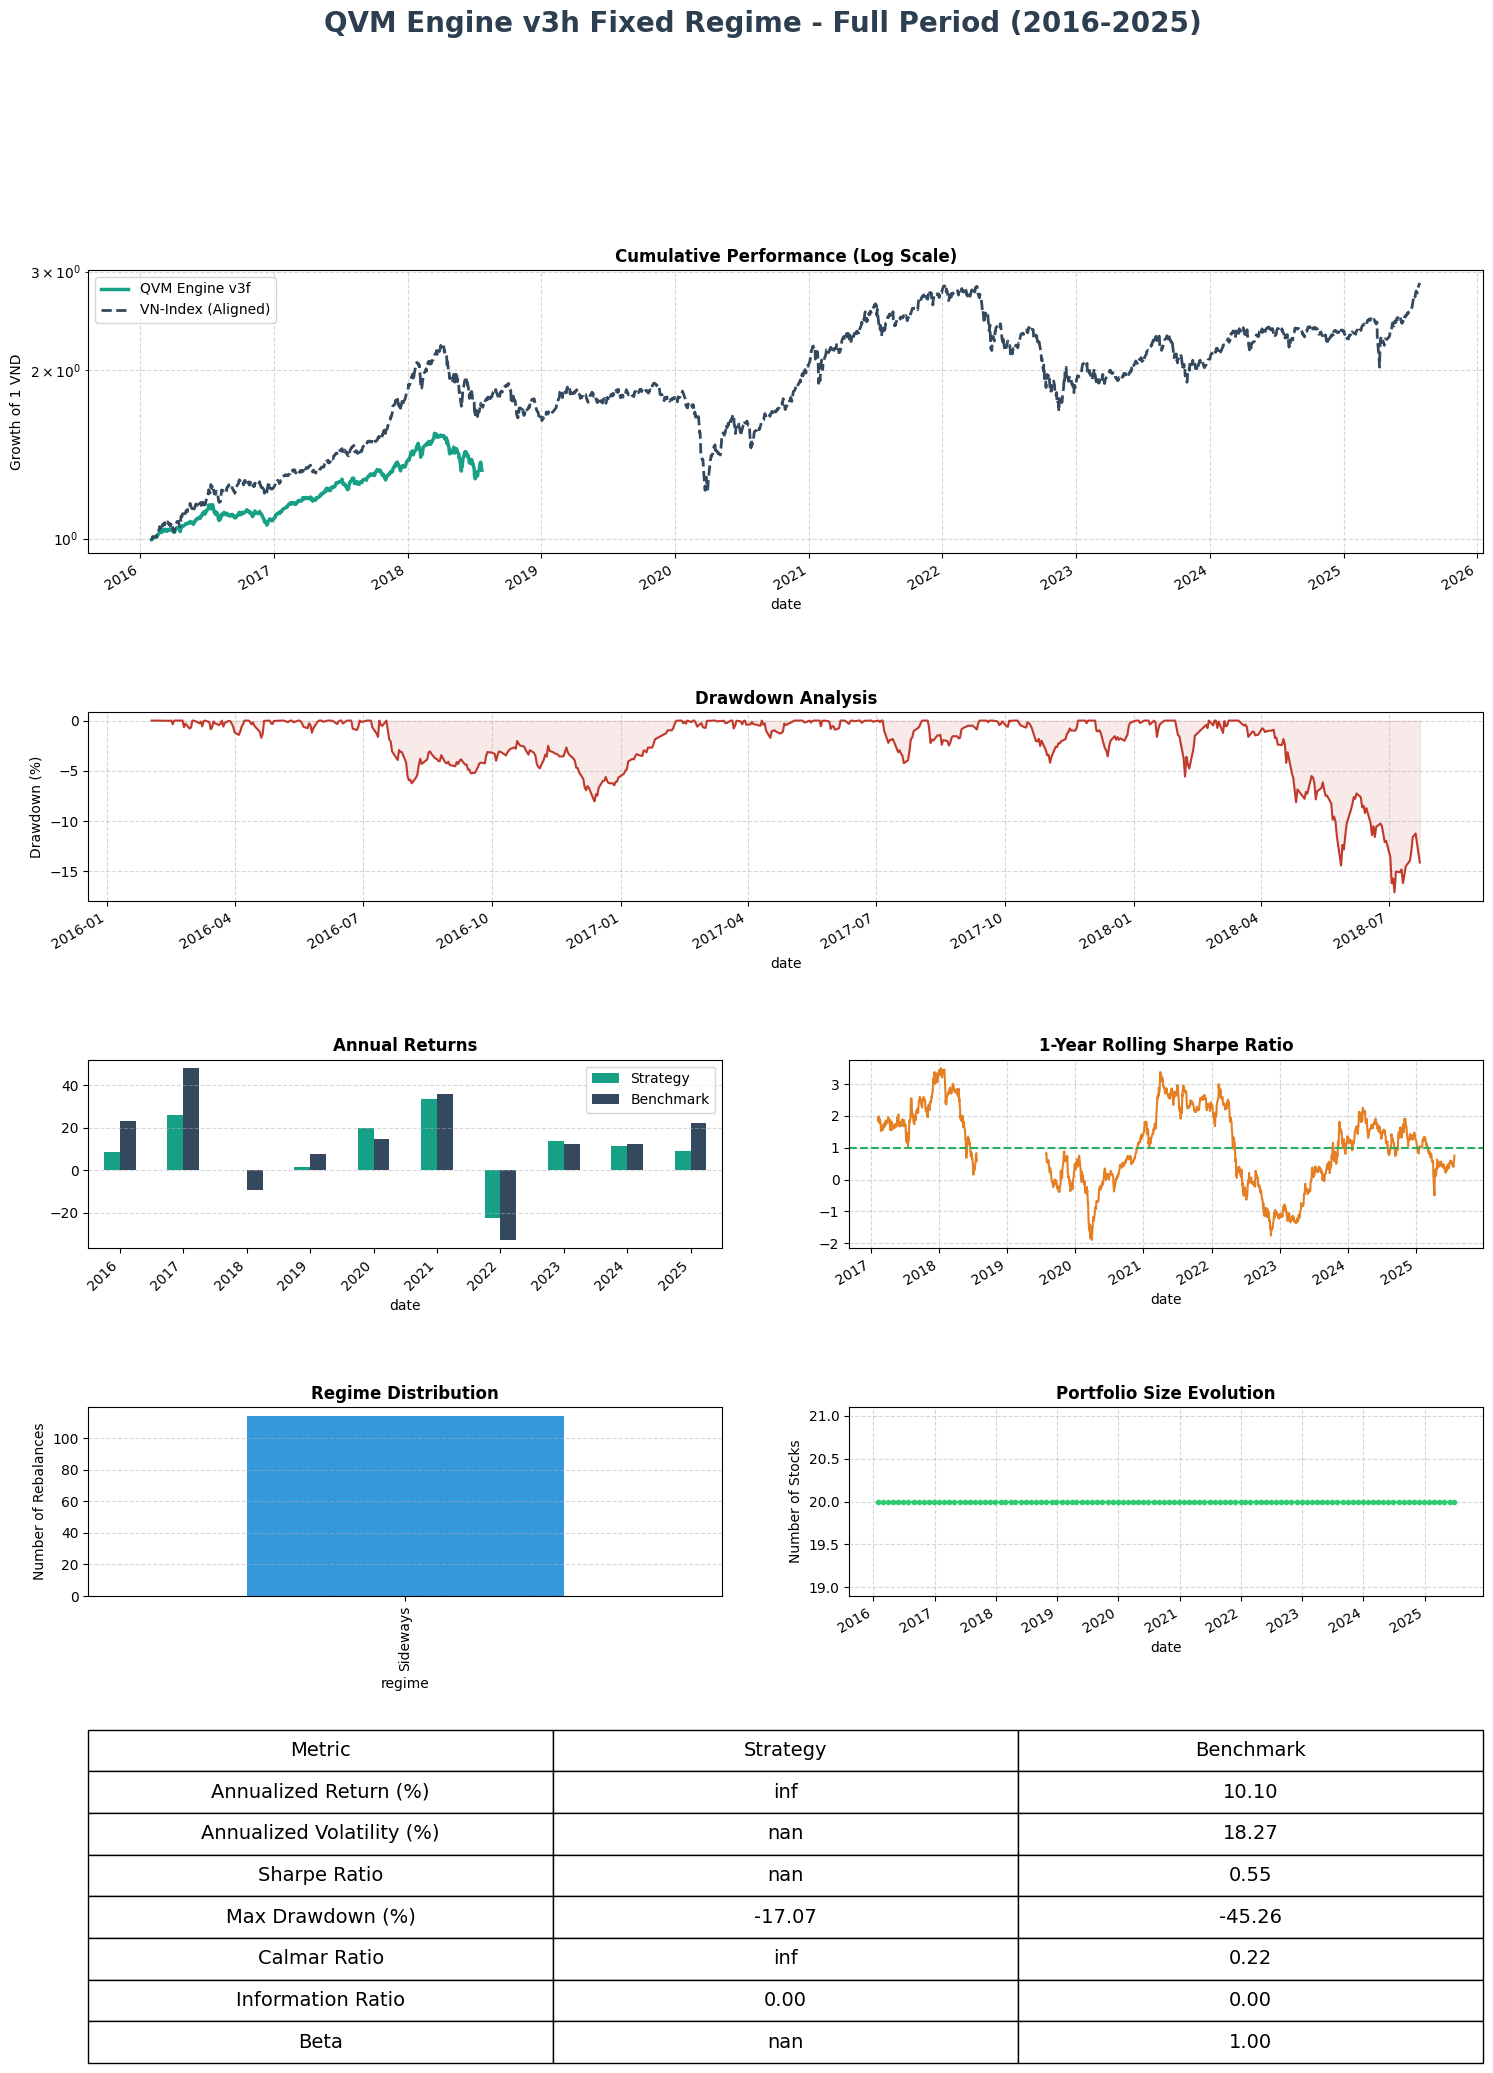


📈 Generating First Period Tearsheet (2016-2020)...


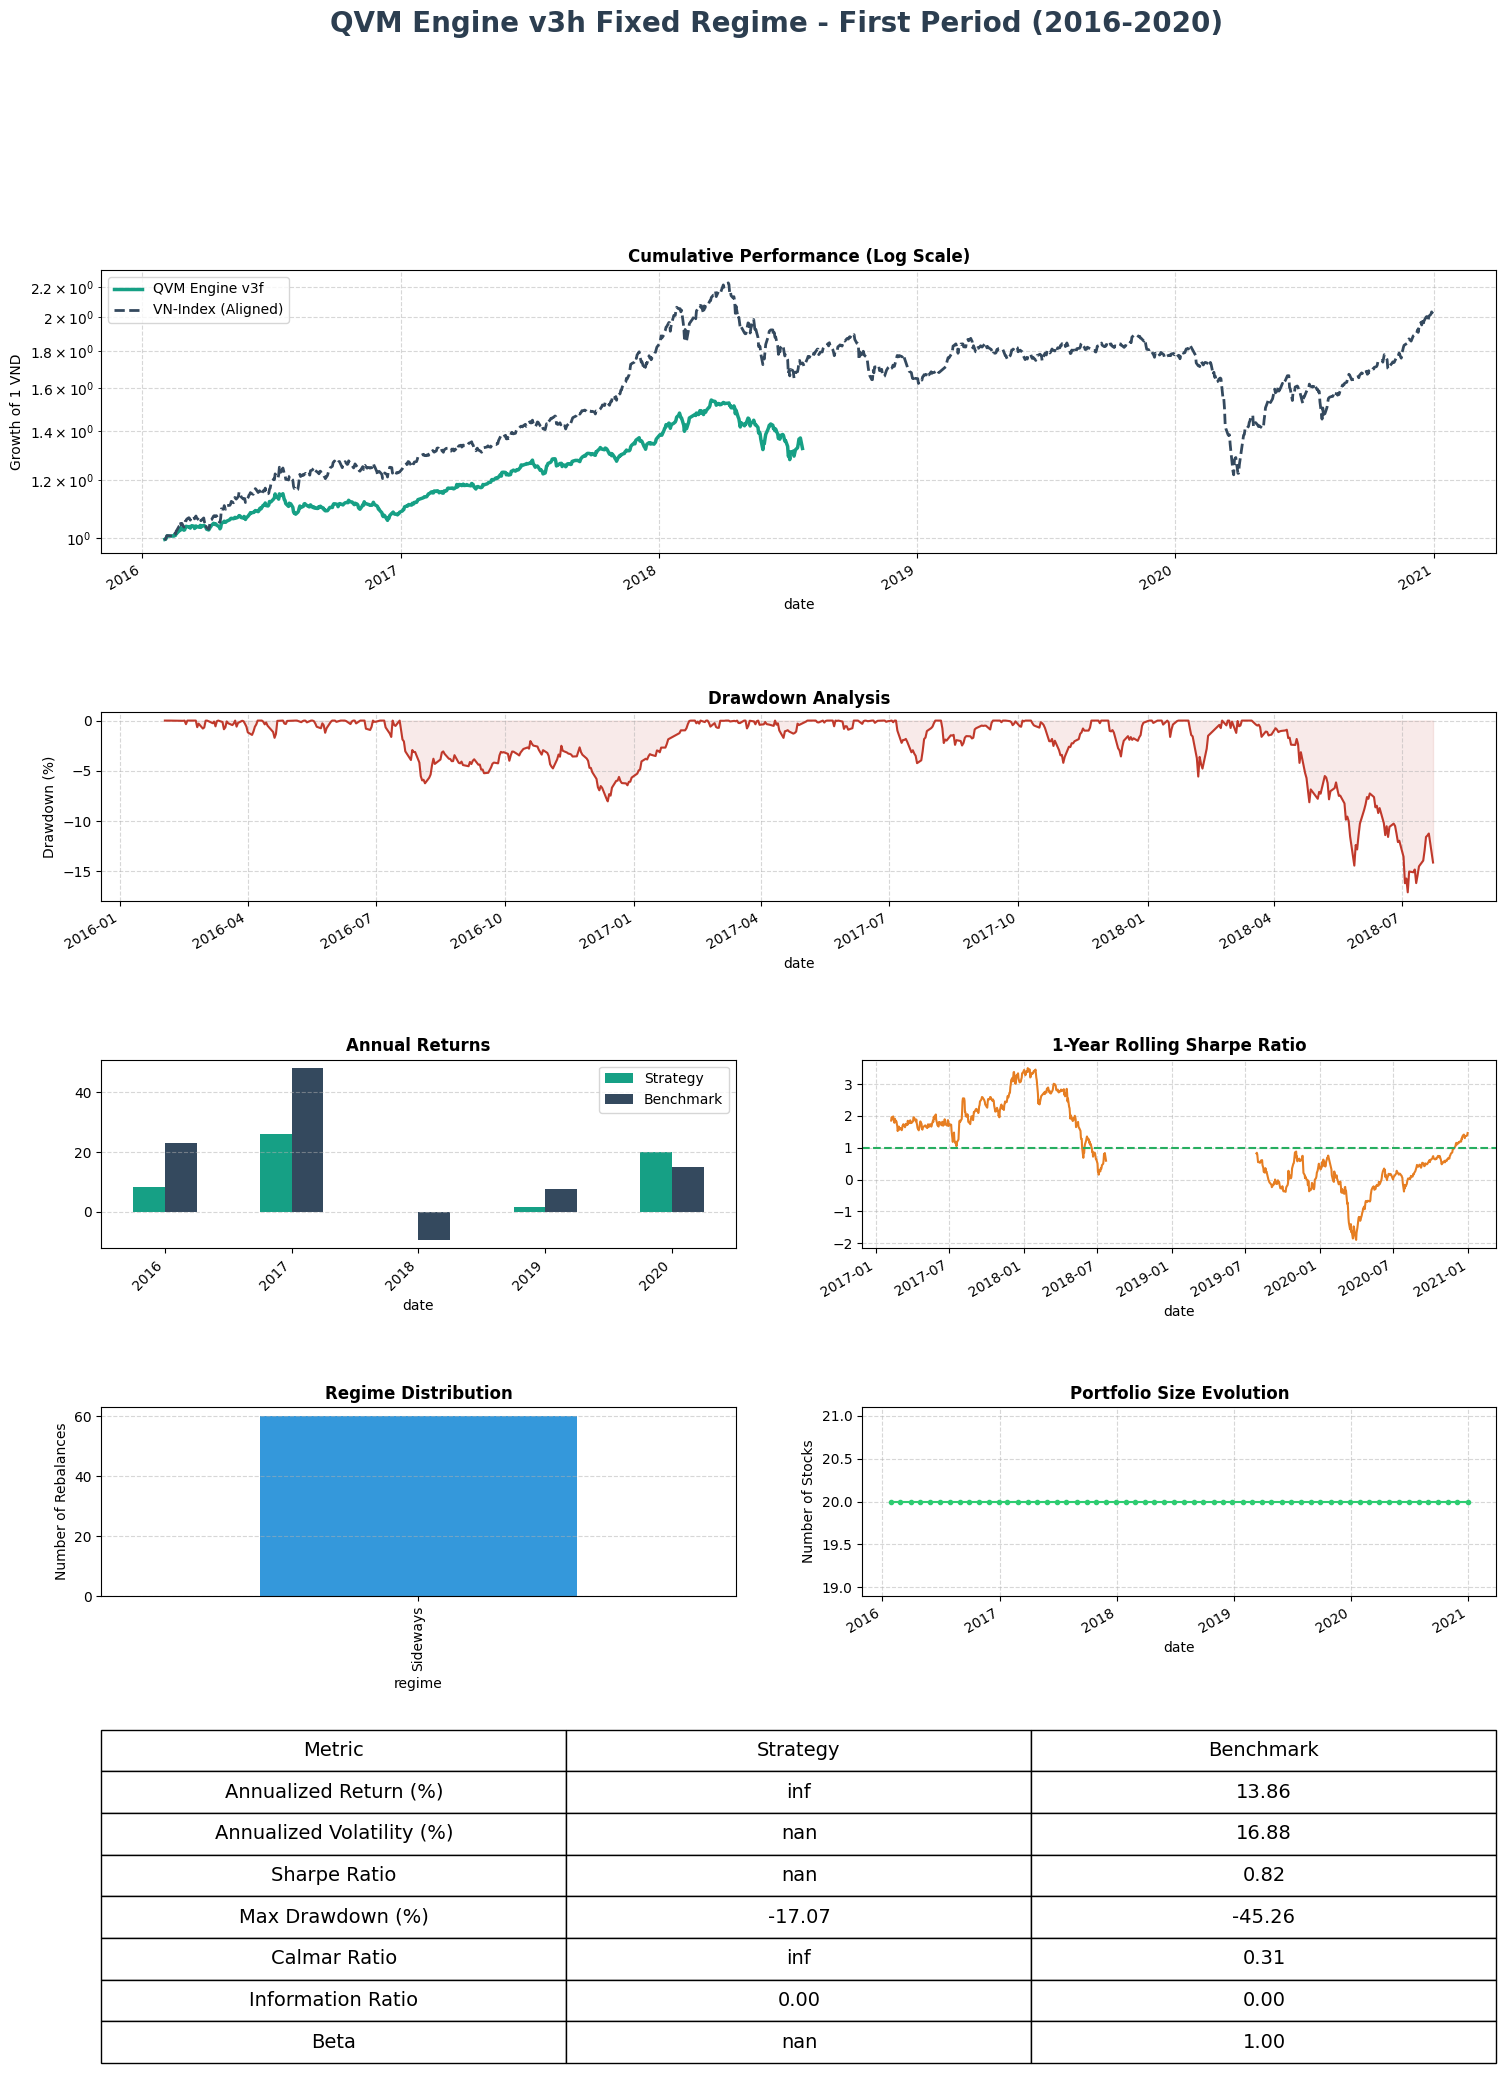


📈 Generating Second Period Tearsheet (2020-2025)...


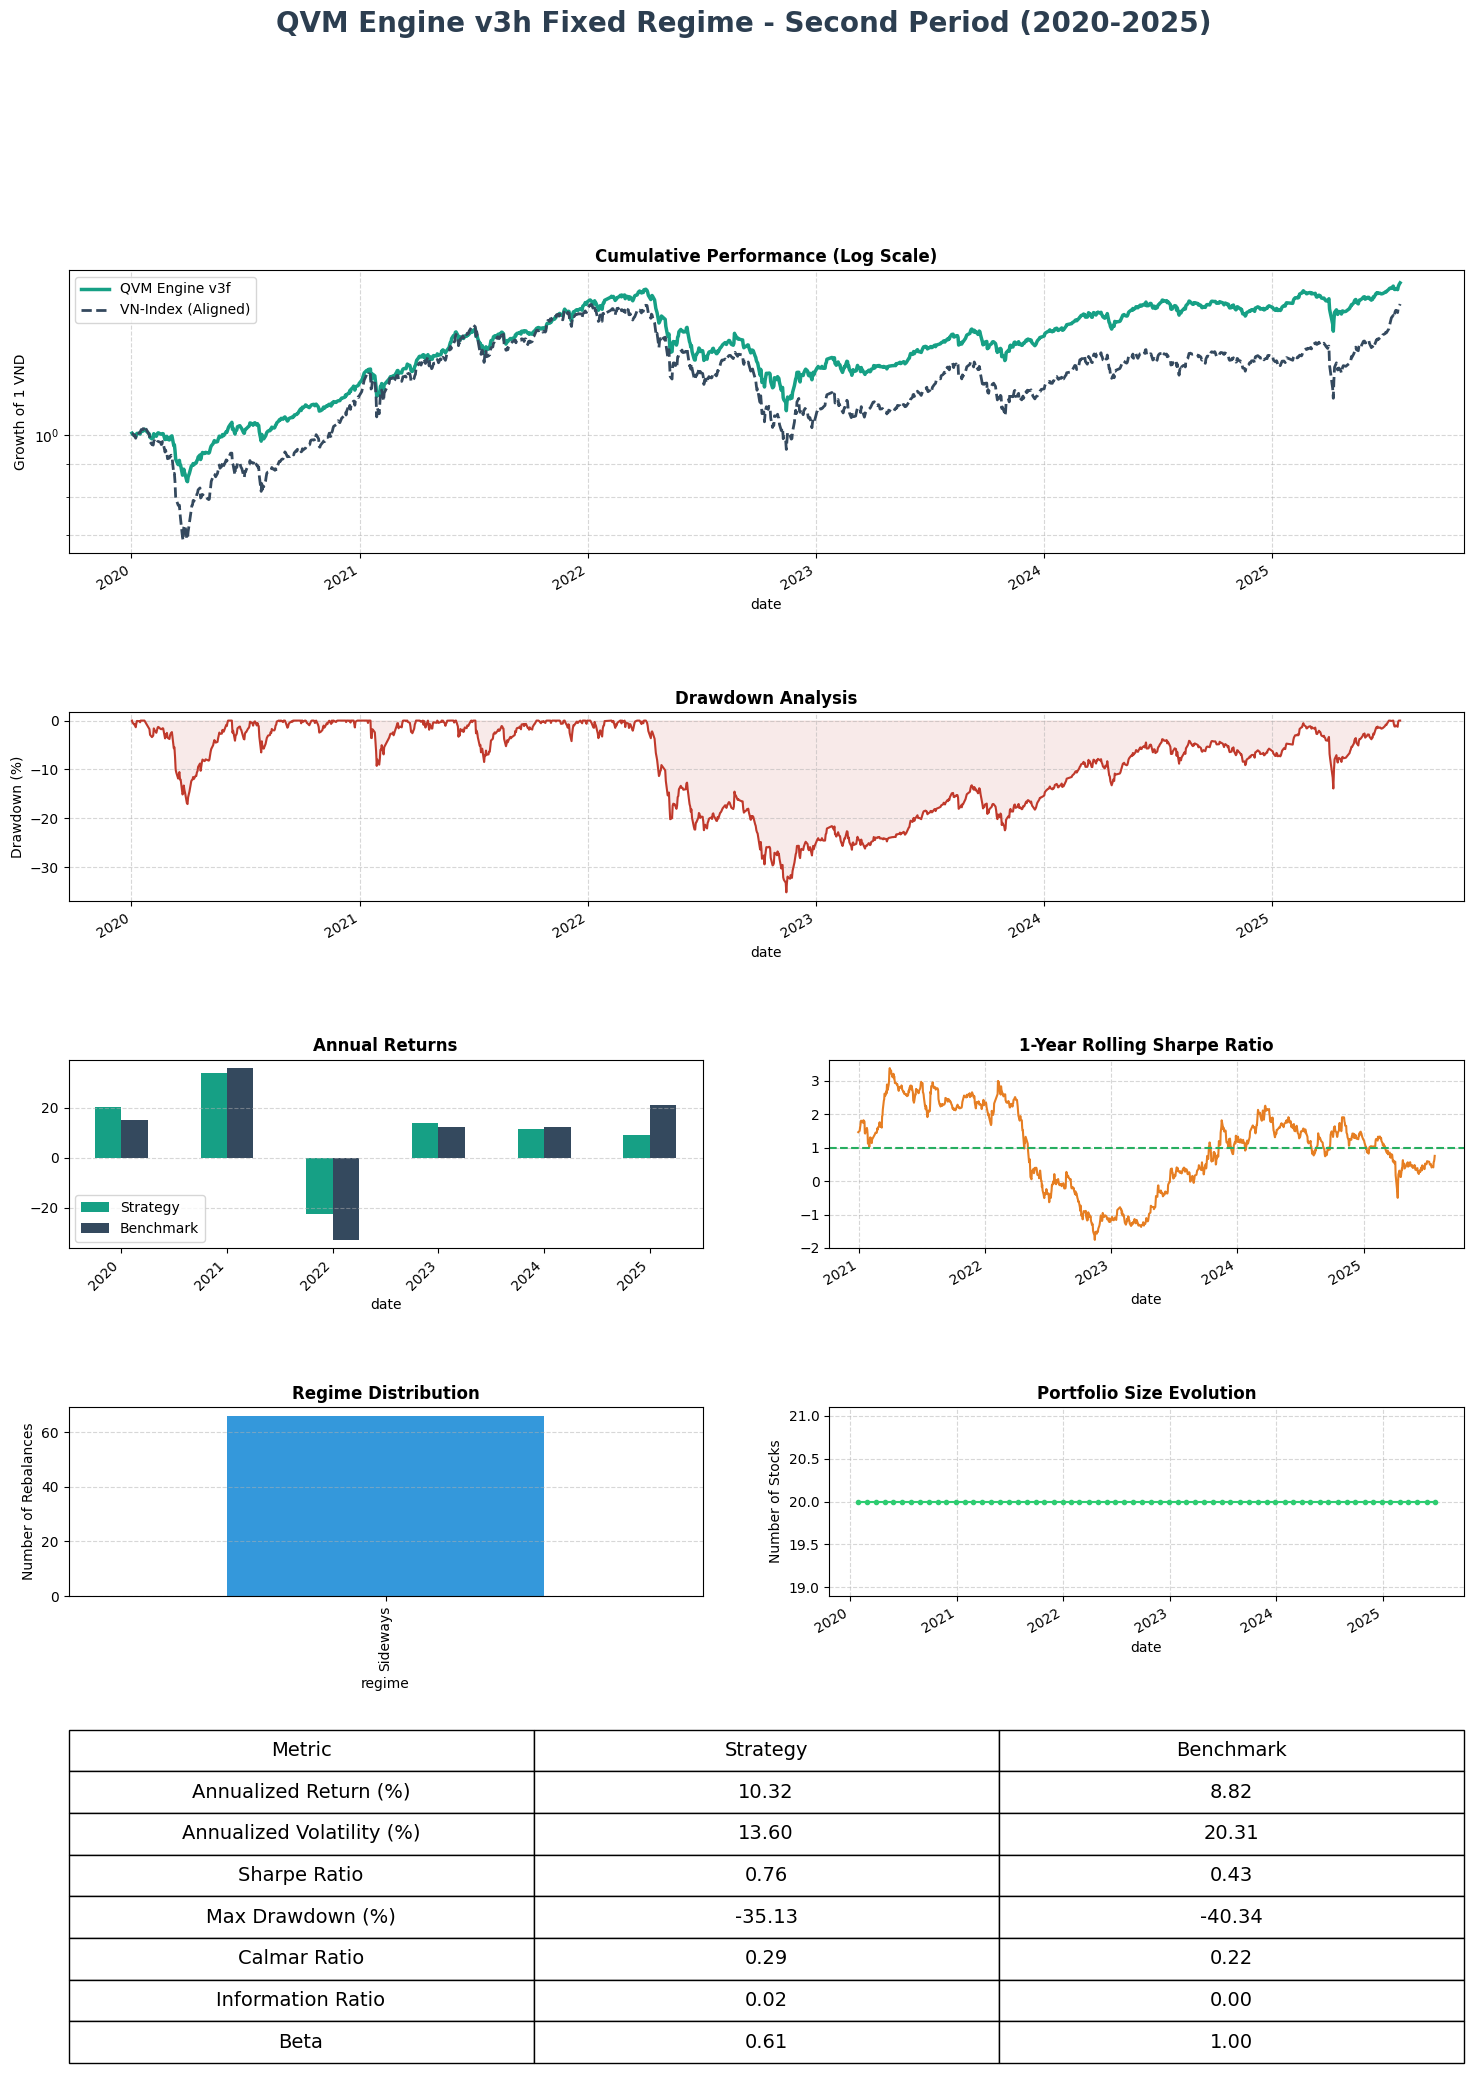


🔍 ADDITIONAL ANALYSIS

📈 Regime Analysis:
   - Sideways: 114 times (100.00%)

📊 Factor Configuration:
   - ROAA Weight: 0.3
   - P/E Weight: 0.3
   - Momentum Weight: 0.4
   - Momentum Horizons: [21, 63, 126, 252]

🌐 Universe Statistics:
   - Average Universe Size: 200 stocks
   - Average Portfolio Size: 20 stocks
   - Average Turnover: 3.01%

✅ QVM Engine v3h Fixed Regime with comprehensive performance analysis complete!


In [53]:
# Execute the data loading
try:
    price_data_raw, fundamental_data_raw, daily_returns_matrix, benchmark_returns = load_all_data_for_backtest(QVM_CONFIG, engine)
    print("\n✅ All data successfully loaded and prepared for the backtest.")
    print(f"   - Price Data Shape: {price_data_raw.shape}")
    print(f"   - Fundamental Data Shape: {fundamental_data_raw.shape}")
    print(f"   - Returns Matrix Shape: {daily_returns_matrix.shape}")
    print(f"   - Benchmark Returns: {len(benchmark_returns)} days")

    # --- Instantiate and Run the QVM Engine v3h Fixed Regime ---
    print("\n" + "="*80)
    print("🚀 QVM ENGINE V3H: FIXED REGIME")
    print("="*80)
    
    qvm_engine = QVMEngineV3fTop200Universe(
        config=QVM_CONFIG,
        price_data=price_data_raw,
        fundamental_data=fundamental_data_raw,
        returns_matrix=daily_returns_matrix,
        benchmark_returns=benchmark_returns,
        db_engine=engine
    )
    
    qvm_net_returns, qvm_diagnostics = qvm_engine.run_backtest()
    
    print(f"\n🔍 DEBUG: After backtest")
    print(f"   - qvm_net_returns shape: {qvm_net_returns.shape}")
    print(f"   - qvm_net_returns date range: {qvm_net_returns.index.min()} to {qvm_net_returns.index.max()}")
    print(f"   - benchmark_returns shape: {benchmark_returns.shape}")
    print(f"   - benchmark_returns date range: {benchmark_returns.index.min()} to {benchmark_returns.index.max()}")
    print(f"   - Non-zero returns count: {(qvm_net_returns != 0).sum()}")
    print(f"   - First non-zero return date: {qvm_net_returns[qvm_net_returns != 0].index.min() if (qvm_net_returns != 0).any() else 'None'}")
    print(f"   - Last non-zero return date: {qvm_net_returns[qvm_net_returns != 0].index.max() if (qvm_net_returns != 0).any() else 'None'}")

    # --- Generate Multiple Tearsheets ---
    print("\n" + "="*80)
    print("📊 QVM ENGINE V3H: MULTIPLE TEARSHEETS")
    print("="*80)
    
    # 1. Full Period Tearsheet (2016-2025)
    print("\n📈 Generating Full Period Tearsheet (2016-2025)...")
    generate_comprehensive_tearsheet(
        qvm_net_returns,
        benchmark_returns,
        qvm_diagnostics,
        "QVM Engine v3h Fixed Regime - Full Period (2016-2025)"
    )
    
    # 2. First Period Tearsheet (2016-2020)
    print("\n📈 Generating First Period Tearsheet (2016-2020)...")
    first_period_mask = (qvm_net_returns.index >= '2016-01-01') & (qvm_net_returns.index <= '2020-12-31')
    first_period_returns = qvm_net_returns[first_period_mask]
    
    # Align benchmark data with strategy returns for first period
    first_period_benchmark = benchmark_returns.reindex(first_period_returns.index).fillna(0)
    
    first_period_diagnostics = qvm_diagnostics[
        (qvm_diagnostics.index >= '2016-01-01') & (qvm_diagnostics.index <= '2020-12-31')
    ]
    
    generate_comprehensive_tearsheet(
        first_period_returns,
        first_period_benchmark,
        first_period_diagnostics,
        "QVM Engine v3h Fixed Regime - First Period (2016-2020)"
    )
    
    # 3. Second Period Tearsheet (2020-2025)
    print("\n📈 Generating Second Period Tearsheet (2020-2025)...")
    second_period_mask = (qvm_net_returns.index >= '2020-01-01') & (qvm_net_returns.index <= '2025-12-31')
    second_period_returns = qvm_net_returns[second_period_mask]
    
    # Align benchmark data with strategy returns for second period
    second_period_benchmark = benchmark_returns.reindex(second_period_returns.index).fillna(0)
    
    second_period_diagnostics = qvm_diagnostics[
        (qvm_diagnostics.index >= '2020-01-01') & (qvm_diagnostics.index <= '2025-12-31')
    ]
    
    generate_comprehensive_tearsheet(
        second_period_returns,
        second_period_benchmark,
        second_period_diagnostics,
        "QVM Engine v3h Fixed Regime - Second Period (2020-2025)"
    )

    # --- Additional Analysis ---
    print("\n" + "="*80)
    print("🔍 ADDITIONAL ANALYSIS")
    print("="*80)
    
    # Regime Analysis
    if not qvm_diagnostics.empty and 'regime' in qvm_diagnostics.columns:
        print("\n📈 Regime Analysis:")
        regime_summary = qvm_diagnostics['regime'].value_counts()
        for regime, count in regime_summary.items():
            percentage = (count / len(qvm_diagnostics)) * 100
            print(f"   - {regime}: {count} times ({percentage:.2f}%)")
    
    # Factor Configuration
    print("\n📊 Factor Configuration:")
    print(f"   - ROAA Weight: {QVM_CONFIG['factors']['roaa_weight']}")
    print(f"   - P/E Weight: {QVM_CONFIG['factors']['pe_weight']}")
    print(f"   - Momentum Weight: {QVM_CONFIG['factors']['momentum_weight']}")
    print(f"   - Momentum Horizons: {QVM_CONFIG['factors']['momentum_horizons']}")
    
    # Universe Statistics
    if not qvm_diagnostics.empty:
        print(f"\n🌐 Universe Statistics:")
        print(f"   - Average Universe Size: {qvm_diagnostics['universe_size'].mean():.0f} stocks")
        print(f"   - Average Portfolio Size: {qvm_diagnostics['portfolio_size'].mean():.0f} stocks")
        print(f"   - Average Turnover: {qvm_diagnostics['turnover'].mean():.2%}")

    print("\n✅ QVM Engine v3h Fixed Regime with comprehensive performance analysis complete!")

except Exception as e:
    print(f"❌ An error occurred during execution: {e}")
    raise 